<div class="alert alert-success">
    <h1 align="center">Lesson 6: Language Models Using RNNs</h1>
    <h3 align="center">Deep Learning in Python Workshop (HamYad Lab, 2018)</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h5>
</div>

## Introduction

A **language model** assigns a probability to every sequence of words.

$$P(w_1, w_2,\dots, w_n)=P(w_1)P(w_2|w_1)P(w_3|w_1,w_2) \times \dots \times P(w_n|w_1,w_2, \dots, w_{n-1})$$

### Applications

- **Translation**: We can compare different orderings of words:
<h6 align="center">P(he likes apple) > P(apple likes he)</h6>
<br>
- **Speech Recognition**: We can choose words:
<h6 align="center">P(he likes apple) > P(apple licks he)</h6>

## Libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from utils import *
from data_utils import Vocabulary
from train_utils import train

from IPython.core.debugger import Pdb  ## DEBUG ##

# setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12., 6.)
pdb = Pdb()
use_gpu = torch.cuda.is_available()

Helper functions

In [2]:
def plot_loss(trn_hist, val_hist):
    plt.plot(trn_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def tokenize_corpus(corpus_path):
    num_lines = len(open(corpus_path, encoding='utf8').read().split('\n'))
    
    # tokenize corpus
    output = ''
    with open(corpus_path, encoding='utf8') as f:
        for line in tqdm_notebook(f, desc='Tokenizing', total=num_lines):
            tokens = tokenizer(line.strip()) + ['\n']
            output += ' '.join(tokens)
    
    # save tokenized corpus
    tok_corpus_path = corpus_path[:-4] + '_tok.txt'
    with open(tok_corpus_path, 'w', encoding='utf8') as f:
        f.write(output)

## Data

- A huge amount of texts containing bilions of words (such as all wikipedia articles).
- But here, we use a rather small corpus containing Rumi's poems (Masnavi).

<img src='imgs/Rumi.jpg' width='40%'/>

<h4 align='center'><a href='https://en.wikipedia.org/wiki/Rumi'>Statue of Rumi in Buca</a></h4>

In [3]:
data_dir = 'data/masnavi'
output_dir = f'{data_dir}/models'

train_data = f'{data_dir}/masnavi.txt'
train_data_tok = train_data[:-4] + '_tok.txt'

### Tokenizing

In [4]:
tokenize_corpus(train_data)

text = open(train_data, encoding='utf8').read().split('\n')[:10]
print(text)

print('\n\nAfter Tokenizing:\n\n')
print(tokenizer('\n'.join(text)))

HBox(children=(IntProgress(value=0, description='Tokenizing', max=13625), HTML(value='')))


['بشنو این نی چون حکایت می\u200cکند\t\t\tاز جدایی\u200cها شکایت می\u200cکند', 'کز نیستان تا مرا ببریده\u200cاند\t\t\tاز نفیرم مرد و زن نالیده\u200cاند', 'سینه خواهم شرحه شرحه از فراق\t\tتا بگویم شرح درد اشتیاق', 'هر کسی کو دور ماند از اصل خویش\t\tباز جوید روزگار وصل خویش', 'من به هر جمعیتی نالان شدم\t\t\tجفت بدحالان و خوش\u200cحالان شدم', 'هرکسی از ظن خود شد یار من\t\t\tز درون من نجست اسرار من', 'سرّ من از نالهٔ من دور نیست\t\t\tلیک چشم و گوش را آن نور نیست', 'تن ز جان و جان ز تن مستور نیست\t\tلیک کس را دید جان دستور نیست', 'آتش\u200cاست این بانگ نای و نیست باد\t\tهر که این آتش ندارد، نیست باد', 'آتش عشق\u200cاست کاندر نی فتاد\t\t\tجوشش عشق\u200c است کاندر می فتاد']


After Tokenizing:


['بشنو', 'این', 'نی', 'چون', 'حکایت', 'می', 'کند', '\t\t\t', 'از', 'جدایی', 'ها', 'شکایت', 'می', 'کند', 'کز', 'نیستان', 'تا', 'مرا', 'ببریده', 'اند', '\t\t\t', 'از', 'نفیرم', 'مرد', 'و', 'زن', 'نالیده', 'اند', 'سینه', 'خواهم', 'شرحه', 'شرحه', 'از', 'فراق', '\t\t', 'تا', 'بگویم', 'شرح', 'درد', 'اشتیاق'

### Statistics

In [5]:
def cal_stats(corpus_path):
    # collect the number of tokens used in each sentence of the corpus in a list
    lengths = [len(s.split(' ')) for s in open(corpus_path, encoding='utf8').read().split('\n')]
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    
    # print stats
    print('Total words in the corpus = {}\n'.format(total))
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(mean-2*std, mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

Total words in the corpus = 171451

Mean = 12.58
Std  = 3.75
95% confidence interval = [5.07, 20.09]


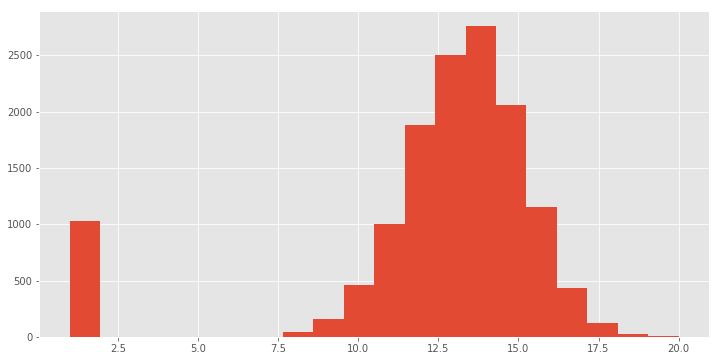

In [6]:
cal_stats(train_data)

### Corpus

In [7]:
class Corpus(object):
    
    def __init__(self, corpus_path='data/train.txt'):
        self.vocabulary = Vocabulary()
        self.corpus_path = corpus_path
        self.num_sentences = len([line for line in open(corpus_path, encoding='utf8')])
    
    def get_data(self, max_vocab=30000, min_count=3, batch_size=20, split_ratio=0.2):
        
        # First pass: add words to the vocabulary
        trn_tokens, val_tokens = [], []
        with open(self.corpus_path, encoding='utf8') as f:
            for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):
                tokens = line.split() + ['<EOS>']
                if len(line) <= 10: continue
                if random.random() < split_ratio:
                    val_tokens += tokens
                else:
                    trn_tokens += tokens
        
        counter = Counter(trn_tokens + val_tokens)
        
        # sort tokens according to their frequencies in the Corpus
        vocabs = [(w, c) for (w, c) in counter.most_common(max_vocab) if c >= min_count]
        
        for i, (word, count) in enumerate(vocabs):
            self.vocabulary.word2index[word] = i
            self.vocabulary.word2count[word] = count
            self.vocabulary.index2word[i] = word
            self.vocabulary.num_words += 1
        self.vocabulary.add_word('<UNK>')
        
        
        # Second pass: Tokenize file content
        UNK_TOKEN = self.vocabulary.word2index['<UNK>']
        
        # train ids
        trn_ids = torch.LongTensor(len(trn_tokens))
        for idx, token in enumerate(trn_tokens):
            if token in self.vocabulary.word2index:
                trn_ids[idx] = self.vocabulary.word2index[token] 
            else:
                trn_ids[idx] = UNK_TOKEN
        
        # validation ids
        val_ids = torch.LongTensor(len(val_tokens))
        for idx, token in enumerate(val_tokens):
            if token in self.vocabulary.word2index:
                val_ids[idx] = self.vocabulary.word2index[token] 
            else:
                val_ids[idx] = UNK_TOKEN
        
        num_batches = trn_ids.size(0) // batch_size
        trn_ids = trn_ids[: num_batches * batch_size]
        
        num_batches = val_ids.size(0) // batch_size
        val_ids = trn_ids[: num_batches * batch_size]

        return trn_ids.view(batch_size, -1), val_ids.view(batch_size, -1)

### Hyper-parameters

In [8]:
max_vocab = 30000
min_count = 1

# LSTM hyper-parameters
embed_size = 1500
hidden_size = 1500
num_layers = 2

# Training hyper-parameters
num_epochs = 40
batch_size = 50
seq_length = 60
learning_rate = 0.001

### Load Data

In [9]:
corpus = Corpus(train_data_tok)
trn_ids, val_ids = corpus.get_data(max_vocab, min_count, batch_size)
vocab_size = len(corpus.vocabulary)

# save vocabs and ids
pickle.dump(corpus.vocabulary, open(f'{data_dir}/vocab.pkl', 'wb'))
np.save(f'{data_dir}/trn_ids.npy', trn_ids.view(-1).numpy())
np.save(f'{data_dir}/val_ids.npy', val_ids.view(-1).numpy())

HBox(children=(IntProgress(value=0, description='Building Vocab...', max=13625), HTML(value='')))

In [10]:
# corpus = Corpus(train_data)
# corpus.vocabulary = pickle.load(open(f'{data_dir}/vocab.pkl', 'rb'))

# trn_ids = torch.LongTensor(np.load(f'{data_dir}/trn_ids.npy'))
# trn_ids = trn_ids[: trn_ids.size(0) // batch_size * batch_size]
# trn_ids = trn_ids.view(batch_size, -1)

# val_ids = torch.LongTensor(np.load(f'{data_dir}/val_ids.npy'))
# val_ids = val_ids[: val_ids.size(0) // batch_size * batch_size]
# val_ids = val_ids.view(batch_size, -1)

In [11]:
vocab_size = len(corpus.vocabulary)
print(vocab_size)
print(trn_ids.size())
print(val_ids.size())

15844
torch.Size([50, 2768])
torch.Size([50, 674])


In [12]:
most_commons = [(w, c) for (w, c) in corpus.vocabulary.word2count.items()][:20]

for w, c in most_commons:
    print(w, c)

<EOS> 12593
و 5867
از 3716
را 3578
در 3084
آن 2901
که 2188
می 2045
او 2008
بر 1947
چون 1736
این 1706
تو 1704
ای 1636
تا 1397
ز 1330
من 1140
گفت 1104
بود 1089
شد 998


## LSTM For Language Modeling

<img src='imgs/deep-rnns.png' width='90%'/>

In [13]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, drop=0.35, tie=True):
        super(LSTM_LM, self).__init__()
        
        if tie:
            embed_size = hidden_size
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
            
        self.dropout = nn.Dropout(drop)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        if tie:
            # Use the same weights both for embedding and classification
            self.fc.weight.data = self.embedding.weight.data
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hidden(self, batch_size):
        return (to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
    def forward(self, x, hidden):
        # embed word ids to vectors
        x = self.embedding(x)
        x = self.dropout(x)  # DROPOUT
        
        # forward RNN step
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)  # DROPOUT
        
        # reshape output to (bs * seq_length, hidden_size)
        x = x.contiguous().view(x.size(0) * x.size(1), x.size(2))
        
        # decode hidden states of all time steps
        x = self.fc(x)
        
        return x, hidden
    
    def save(self, epoch, loss, save_to=output_dir):
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        filename = output_dir + '/lm-masnavi-epoch-{}-em-{}-hi-{}-nl-{}-{:.2f}-{:.2f}.pth'.format(
            epoch, self.embed_size, self.hidden_size, self.num_layers, loss, np.exp(loss))
        torch.save(self.state_dict(), filename)

#### Tie Weights (Embedding and classification)

<h6>Idea:</h6> Reuse Embeddings for Classification, which greatly reduces the number of trainable parameters:
- [Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016)](https://arxiv.org/pdf/1611.01462.pdf)

### Define model

In [14]:
# model
model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, drop=0.65)
if use_gpu:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### Training

In [15]:
hist = train(model, trn_ids, val_ids, 
             criterion, optimizer, scheduler, 
             num_epochs, batch_size, seq_length)

Validation: Epoch [40/40], Step [11/11], Loss: 0.780, Perp: 2.18, Acc: 0.88             

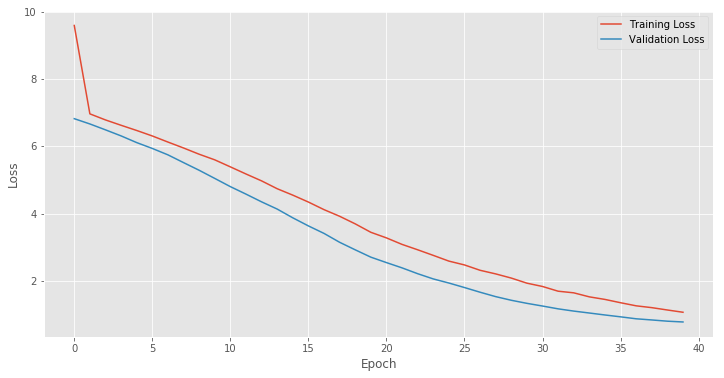

In [16]:
plot_loss(*hist)

In [18]:
torch.save(model.state_dict(), 'masnavi-lm.pth')

### Sampling

<h6>Algorithm:</h6>
1. **Initialize** the LSTM state (`h`, `c`) with zeros.

2. Pick a **random word** from vocabulary as the seed.

3. while number of generated samples is less than the desired:
 
 3.1 **Feed** the LSTM using the word generated from previous time-step.
 
 3.2 Perform **forward computations** to create the probabilty distribution vector for vocabularies.
 
 3.3 Pick a **random word** from vocabulary according to the probabilty distribution from LSTM.

<img src='imgs/rnn-sampling.png' width='90%'/>

#### Multinomial distribution

In [17]:
N = 1000
p = torch.FloatTensor([0.5, 0.25, 0.15, 0.10])
# p = torch.FloatTensor([50, 25, 15, 10])

counter = Counter()

# Draw N samples
for _ in range(N):
    sample = torch.multinomial(p, num_samples=1, replacement=True)[0]
    counter[sample] += 1
    
# print samples and their counts
for sample, count in counter.most_common():
    print("{:d}: {:2d}".format(sample, count))

0: 506
1: 258
2: 144
3: 92


In [19]:
def get_sample(model, sample_len):
    model.eval()
    sample = ''
    state = model.init_hidden(1)

    # select a random word id to start sampling
    probs = torch.ones(vocab_size)
    inp = to_var(torch.multinomial(probs, num_samples=1).unsqueeze(1), volatile=True)

    for i in tqdm_notebook(range(sample_len)):
        output, state = model(inp, state)

        # Sample an id
        probs = output.squeeze().data.exp().cpu()
        word_id = torch.multinomial(probs, 1)[0]

        # Feed sampled word id to next time step
        inp.data.fill_(word_id)

        # write to file
        word = corpus.vocabulary.index2word[word_id]
        if word == '<EOS>':
            sample += '\n'
        else:
            sample += ' ' + word
    
    return sample

In [21]:
sample = get_sample(model, 300)
print(sample)

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))


 و آن وزیر
 بوک از بهر عیسی گر گریخت وز کف فتح بدند
 هر که باشد در جهان فال کند در دگر هر گام مستی دهد
 هر یکی گوید که کوران ترا سر بمخزنها و گندم حالت کنم
 گفته باشد سر آهو نه وجود هر کسی کو شیشه باشد در الست
 صاحب کس را چو صیاد می دهند وآن دگر را کم بیابد یک نظر
 پس قیامت هم شهان زین جمله در دم زن قدرست چون پارسی
 گر مرا شمه ای زان خصال مر مرا که نباشد هم ز من نزدیکتر
 این ترا غمگین نشان این قوم را تا ببینی حق بلا را و نشان
 بر سر امرودبن پر نهاد بر گردون عقبه پایگی
 هم چنین زیشان نهان را همچو مست چون شود بر هیچ میر و بس
 سوخته را گنج شهان در خورست باید گری تا بر زند
 اصل بی برگی درین سو در رود چون در آمد میان جان شدند
 مرد بی خر شد به یک روز زحف آنچ رایی شد خیال و سود شد
 چون قضا جانش شوی یاری شود عقل دیگر هست از عقلی به
 گر برو نوری شود من کان بگیرد همچو گرگ آفتاب پرواز
 ای پدر می دان که من آنم ز روی شاه من پرورد در زمن
 مولعیم چون افسانه ها در سوخته گر بروید این بلای یا رب
 یا دریغا پیش من جان ترا می تاخت این بدان را در حسد
 اینک آن باشد که اندر وی درم عاقبت باشد لقب عاقبت
 روی ب

In [ ]:
with open('sample.txt', 'w', encoding='utf8') as f:
    f.write(sample)

## Load a pre-trained Model

In [22]:
model = LSTM_LM(vocab_size, embed_size=1500, hidden_size=1500, num_layers=2)
model.load_state_dict(torch.load('masnavi-lm.pth'))
if use_gpu:
    model = model.cuda()

In [23]:
sample = get_sample(model, 300)
print(sample)

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))



 گر تو خوردم و قضای مر تو زیشان تو سخاست
 انبیا را صدق دقیق گو آن بسحر را بنما
 باز باید همچو نازیبا را شرح چون دیده گیر هم خام
 باطلان کم اشتران جمله نظر از عوانی بر بکردند
 گر به تازی می زهی تا به آخر حقایق می برند
 گر حقیقت چون برقصست می کنند از بسیط می شوی
 می فتد اندر نظر زخم می می کنم تا طیور
 وقت تو سوی نرفتی می شدند زانک فردا بانگ می کنند
 گفت دنیا هست اما هین کین معشوق داد در انجمن
 که به دست می درند وز دگر بر بخارا می ناپدید
 گفت لقای سوگند آزاد ماهیان بر بر خوری بر خندیدنست
 دانه باید بر قدم لحن باشد کز بر عقلیم
 هست باشد زان اخوان کفشگر ساخت جان جمله شستند
 همچو بر خوردم و اشک جمله بر آمدش محکم
 جمله بر جد خشمم بر حشر بر بر بیند نهاد
 که قدم می کند پنهان او چون نماید چون کند او جعل
 تو به رقت باید وین آنچنان از اعتبار بگریختند
 نه همه پیش بخارا و حیات عشق و روز خراب و روسیاه
 گر تو تا باشم ار دو ور تنها علی ای مطاع
 شرح ده گفتن ناموسی همچو کلی و در خورشیدی
 هست دنیا به آتش بگشت کی عمارتها بر بر دریا نهاد
 گر مخلوق در کف بیرون بود کز اسیر خسته است
 ور و جور را روزی صد راه 

### Dropout in RNNs

Droput is ineffective for recurrent layers (evantually all hidden units goes to zero)
- Easy solution: use dropout only at the input and output of recurrent layers.
- Also, it is possible and common to use dropout between recurrent layers at different depths.

<img src='imgs/rnn-dropout.png' width='70%'/>

```python
def forward(self, inp, hidden):
    # embed word ids to vectors
    x = self.embedding(inp)
    x = self.dropout(x)  ### DROPOUT ###
        
    # forward RNN step
    x, hidden = self.lstm(x, hidden)
    x = self.dropout(x)  ### DROPOUT ###
    ...
```

## Other Language Models

- Character level language models

<img src='imgs/lm-char-level.png' width='50%'/>

- Sub-word level language models

<img src='imgs/lm-subword-level.png' width='70%'/>

## Furthere Reading

- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Oxford Deep NLP 2017 course](https://github.com/oxford-cs-deepnlp-2017/lectures)
- [Natural Language Processing with Deep Learning - Stanford](https://youtu.be/OQQ-W_63UgQ)
- [Deep Learning Book - Chapter 10](http://www.deeplearningbook.org/contents/rnn.html)